## What CPU and GPU am I using?

Before we start, lets check what processor and GPU we will be using. Performance can vary a lot depending on which model we are using. Google Collab does not allow us to choose the model, but it is free.

In [1]:
!echo "CPU:"
!cat /proc/cpuinfo | grep name
!echo "GPU:"
!nvidia-smi

CPU:
model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
GPU:
Mon Feb  1 16:49:02 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   66C    P8    11W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+--------------

## Matrix Multiplication

We start by importing numpy and numba. We also define a checksum function as a fast checking mechanism. **In this case, we use as checksum the sum of all elements divided by N^2, where N is the dimension of the matrix. Other types of checksum could be implemented.**

**We will assume that we have a square matrix (N x N).** 

In [2]:
# conda install numba cudatoolkit=10.1
import time
import numpy as np
from numpy.random import seed
from numpy.random import rand
from numba import jit,njit,prange,cuda, types, float32
import matplotlib.pyplot as plt

%matplotlib inline 

seed(1)
def randomize_array(size):
    lst = 10.*rand(size)+1.
    return lst

mat_size = 256
mat_size_sq = mat_size*mat_size
a = np.array(randomize_array(mat_size_sq), dtype=np.float32)
b = np.array(randomize_array(mat_size_sq), dtype=np.float32)

# Compile and run the check in parallel with Numba
# (we do this to keep this part fast, but it is not the main objective of the execise)
@njit(parallel = True)
def check(c, N):
    NN = N * N
    sum = 0.0
    for i in prange(NN):
        sum += c[i] / NN
    return sum

### Interpreted Matrix Multiplication

Next, we implement the standard matrix-multiplication algorithm. With the current matrix size N=256*256, it takes about 15s to complete.

In [3]:
def mat_mul_base(a,b,c,size):
    for i in range(size):
        for j in range(size):
            for k in range(size):
                c[i*size+j]+=a[i*size+k]*b[k*size+j]
                
c = np.zeros(mat_size_sq, dtype=np.float32)
start = time.time()
mat_mul_base(a, b, c, mat_size)
end = time.time()

print('Elapsed time: ',end-start)
print(check(c, mat_size))

Elapsed time:  11.97942066192627
9217.815409995615


/usr/local/lib/python3.6/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


### Compiled Matrix Multiplication

Python is an interpreted language, which means standard loops like these are very, very slow...

Fortunately, we can use numba to compile this kernel just-in-time. The performance will be comparable to C or FORTRAN code!
It should take less than a second with the same matrix size.

In [4]:
@njit
def mat_mul_numba(a,b,c,size):
    for i in range(size):
        for j in range(size):
            for k in range(size):
                c[i*size+j]+=a[i*size+k]*b[k*size+j]
                
c = np.zeros(mat_size_sq, dtype=np.float32)
start = time.time()
mat_mul_numba(a, b, c, mat_size)
end = time.time()

print('Elapsed time: ',end-start)
print(check(c, mat_size))

Elapsed time:  0.23107171058654785
9217.815409995615


We are going to optimize this code a lot. So from now on, we will use a much larger matrix size. Let's try again. This should take less than 1 min.

In [5]:
mat_size = 2048
mat_size_sq = mat_size*mat_size
a = np.array(randomize_array(mat_size_sq), dtype=np.float32)
b = np.array(randomize_array(mat_size_sq), dtype=np.float32)

In [6]:
c = np.zeros(mat_size_sq, dtype=np.float32)
start = time.time()
mat_mul_numba(a, b, c, mat_size)
end = time.time()

print('Elapsed time: ',end-start)
print(check(c, mat_size))

Elapsed time:  28.777310132980347
73721.29736233875


### Cache efficiency

The standard implementation that we have above, with loops on i, j, k is actually not very cache-friendly. It accesses memory cells that are always very far apart in memory. A well-known trick is to switch the k and j loop so that most memory accesses become continous in memory for matrix c and b. This **greatly** improves cache-efficiency, and performance. See by yourself!

In [7]:
@njit
def mat_mul_numba_opt(a,b,c,size):
    for i in range(size):
        for k in range(size):  # We just switched j and k
            for j in range(size):
                c[i*size+j]+=a[i*size+k]*b[k*size+j]
                
c = np.zeros(mat_size_sq, dtype=np.float32)
start = time.time()
mat_mul_numba_opt(a, b, c, mat_size)
end = time.time()

print('Elapsed time: ',end-start)
print(check(c, mat_size))

Elapsed time:  14.243457794189453
73721.29736233875


### Parallelization on CPU

**Note: Google Collab only let you use one CPU, so you will not benefit from parallelization.**

To have a fair comparison with the GPU code that we are going to see in the next section, we can parallelize the CPU code. With 8 CPU cores, the code sould run ~8 times faster.
This will be our baseline code to compare against the GPU code!

In [8]:
@njit(parallel = True)   # we add the option parallel=True to enable threading
def mat_mul_numba_parallel(a,b,c,size):
    for i in prange(size):  # we use prange instead of range. This is the loop being parallelized.
        for k in range(size):
            for j in range(size):
                c[i*size+j]+=a[i*size+k]*b[k*size+j]
                
c = np.zeros(mat_size_sq, dtype=np.float32)
start = time.time()
mat_mul_numba_parallel(a, b, c, mat_size)
end = time.time()

print('Elapsed time: ',end-start)
print(check(c, mat_size))

Elapsed time:  12.902149200439453
73721.29736233875


### GPU CUDA implementation

Below is the CUDA equivalent of the previous code.

**How many threads?**

We create a grid of 2048*2048 threads, in other words, we have one thread per matrix cell.

The GPU does not have enough CUDA cores to execute all of our 2048*2048 threads in parallel. But we don't care. The GPU will take care of this and schedule the work accordingly.

**What does a thread compute?**

Each thread will compute the inner k loop of the previous code. In other word, each thread will compute the dot product between column **i** of matrix **a** and row **j** of matrix **b**.

In fact, we don't need the loops on i and j anymore, because we have one thread per i,j corrdinate.
Note that inside the kernel, a thread knows what cell to compute by fetching its coordinates in the grid. This is the only way to differentiate two threads apart!

**What is the block size?**

We must specify the block size, a.k.a **the number of threads per block**. This must be a **multiple of 32**, and the optimal value will vary by code and by architecture. The upper limit is somwhere around 1024 and 4096, which amounts to 32\*32 to 64\*64 for two-dimensional blocks.

Here, we define a block of threads to be 16\*16 = 256 threads. Therefore, we will have 256 threads per block.
Feel free to try different threads per block (TPB) values below! This can greatly affect performance.

**What is the grid size?**

Now that we have defined the block size, we can compute the grid size. Remember, we want the grid size to be at least 2048\*2048 threads. However, the size of the grid must be given in number of blocks. Therefore, we can simply define:
- grid_size = mat_size / TPB = 2048 / 16 = 128 blocks in one dimension.

And the grid has grid_size\*grid_size = 128\*128 = 16384 blocks of threads in total.

Note that our grid indeed has exactly 16384 \* 256  = 2048 \* 2048 threads.

**How to launch the kernel?**

We launch the CUDA kernel by passing our number of blockspergrid and threadsperblock. The GPU will dispatch the blocks to its streaming multiprocessors where they will be executed in locksteps of 32 threads (warping).

**How fast is it?**

Let's try it out!

In [13]:
@cuda.jit
def mat_mul_numba_cuda(a,b,c,size):
    i=cuda.blockIdx.y*cuda.blockDim.y+cuda.threadIdx.y
    j=cuda.blockIdx.x*cuda.blockDim.x+cuda.threadIdx.x
    
    if i >= size or j >= size:
        return
    
    for k in range(size):
        c[i*size+j]+=a[i*size+k]*b[k*size+j]

TPB = 16
threadsperblock = (TPB,TPB)
grid_size = int(np.ceil(mat_size / TPB))
blockspergrid = (grid_size,grid_size)

c = np.zeros(mat_size_sq, dtype=np.float32)
start=time.time()
mat_mul_numba_cuda[blockspergrid, threadsperblock](a,b,c,mat_size)
end=time.time()

print('Elapsed time: ',end-start)
print(check(c, mat_size))

Elapsed time:  0.3329610824584961
73772.7402311638


### Performance

This should be pretty fast! Note that the time here includes the time needed to copy matrices a and b to the GPU, and then matrix c back to the cpu. Transferring data is often a major bottlneck on the GPU. The execution of the kernel itself is often much faster.

Because the complexity of the matrix-matrix multiplication is O(n^3), the number of computations grow much faster compared to the amount of memory required O(n).

**One can expect the GPU to perform better compared to the CPU with larger matrix sizes.**

Let's see if this is true!

Matrix size: 64 GPU speed-up: 0.18558558558558558
Matrix size: 128 GPU speed-up: 1.7347585114806017
Matrix size: 256 GPU speed-up: 6.913952390586014
Matrix size: 512 GPU speed-up: 35.62650499530356
Matrix size: 1024 GPU speed-up: 58.8029167510634
Matrix size: 2048 GPU speed-up: 70.26067335976722


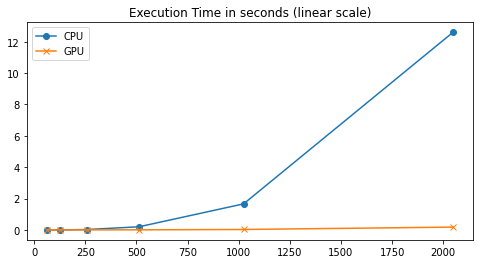

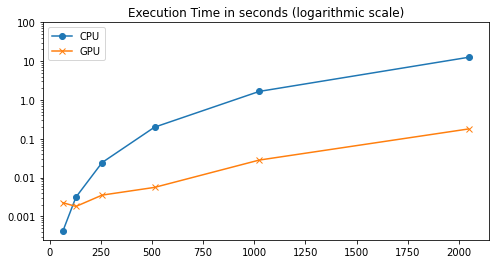

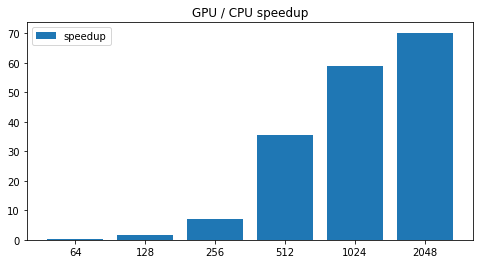

In [10]:
cpu_times = []
gpu_times = []
speedups = []

TPB = 16
threadsperblock = (TPB,TPB)
grid_size = int(np.ceil(mat_size / TPB))
blockspergrid = (grid_size,grid_size)

sizes = [64, 128, 256, 512, 1024, 2048]#, 4096]
for mat_size in sizes:
    mat_size_sq = mat_size*mat_size
    a = np.array(randomize_array(mat_size_sq), dtype=np.float32)
    b = np.array(randomize_array(mat_size_sq), dtype=np.float32)
    
    # CPU
    c = np.zeros(mat_size_sq, dtype=np.float32)
    start = time.time()
    mat_mul_numba_parallel(a, b, c, mat_size)
    end = time.time()
    ctime = end-start
    cpu_times.append(ctime)
    
    # GPU
    c = np.zeros(mat_size_sq, dtype=np.float32)
    start=time.time()
    mat_mul_numba_cuda[blockspergrid, threadsperblock](a,b,c,mat_size)
    end=time.time()
    gtime = end-start
    gpu_times.append(gtime)
    
    speedups.append(ctime/gtime)
    print('Matrix size:',mat_size, 'GPU speed-up:',ctime/gtime)

plt.figure(figsize=(8,4))
plt.plot(sizes, cpu_times, marker='o', markevery=1, label='CPU')
plt.plot(sizes, gpu_times, marker='x', markevery=1, label='GPU')
plt.legend(loc='upper left')
plt.title('Execution Time in seconds (linear scale)')
plt.draw()

plt.figure(figsize=(8,4))
plt.semilogy(sizes, cpu_times, marker='o', markevery=1, label='CPU')
plt.semilogy(sizes, gpu_times, marker='x', markevery=1, label='GPU')
plt.legend(loc='upper left')
plt.yticks([0.001, 0.01, 0.1, 1.0, 10, 100],[0.001, 0.01, 0.1, 1.0, 10, 100])
plt.title('Execution Time in seconds (logarithmic scale)')
plt.draw()

plt.figure(figsize=(8,4))
plt.bar(np.arange(0,len(speedups)), speedups, label='speedup')
plt.legend(loc='upper left')
plt.xticks(np.arange(0,len(speedups)), sizes)
plt.title('GPU / CPU speedup')
plt.draw()

plt.show()

### How to interpret the results

**First plot:** You should see three plots. The first plot shows the execution time (how long it took to execute the matrix-multiplication in seconds) for different matrix sizes from 64x64 to 2048x2048. As you can see, it took a lot longer for the CPU to compute the largest matrix-sizes. The GPU was always able to finish the computation in under 2 seconds!

 **Second plot:** This exactly the same thing, but now on a logarithmic scale for the y axis. The logarithmic scale is useful when comparing very different numbers! Indeed, now it is clear that even though the GPU is always fast, it also needs more time to compute larger matrix sizes. In fact, this plot shows that the GPU is about 1 to 2 orders of magnitude (10x-100x) faster than the CPU for this task! 

**Third plot:** This is the ratio CPU_TIME / GPU_TIME. This is exactly how much faster the GPU is compared to the CPU. It shows that not only the GPU is much faster than the CPU, it is also more efficient with largest matrix sizes! One reason for this is simple: you need a fixed time to send the data to/from the GPU, which scales linearly O(n). However, the amount of computations scales as O(n^3). Simply put: with largest matrix sizes, we spend more time doing computation and less time copying data, which result in a more efficient use of our time, which makes the GPU even better than the CPU for this task!


## Further optimizations: using shared memory

Below we define a block matrix-matrix multiplication algorithm to help reduce the number of accesses to the global GPU memory. CUDA provides a fast shared memory for threads in a block to cooperately compute on a task. 

Matrix a and b are divided into blocks of size `TPB*TPB`, where TPB is also the number of threads per cuda block. Here we define TPB = 16, which means there will be `16*16 = 256` threads per cuda block.

Because the shared memory is a limited resources, the code preloads a small block at a time from the global GPU memory. Then, it calls syncthreads() to wait until all threads have finished preloading and before doing the computation on the shared memory.

In each loop, we do the following:
* Because the shared memory is a limited resources, the code preloads a small block at a time from the input arrays. It calls syncthreads() to wait until all threads have finished preloading and before doing the computation on the shared memory.
```
for i in range(bpg):
    # Preload data into shared memory
    sA[ty * TPB + tx] = a[(ty + i * TPB) * size + x]
    sB[ty * TPB + tx] = b[y * size + tx + i * TPB]
```
This fills the local shared memory with the corresponding block values from the global GPU memory.

* Next, all of our 256 threads will execute the following instructions:
```
# Computes partial product on the shared memory
for j in range(TPB):
    tmp += sA[j * TPB + tx] * sB[ty * TPB + j]
```
which actually compute the block-block multiplication between block sA and sB.  It synchronizes again after the computation to ensure all threads have finished with the data in shared memory before overwriting it in the next loop iteration.

### Analysis:
* Original matrix-matrix algorithm. Each thread compute a `line * column` product, which requires `2 x size` reads and performs `size` operations.
* Block matrix algorithm: each thread computes `size / BSIZE` matrix blocks. For each block, a thread reads `2` (!) values and performs `BSIZE` operations. In total, a thread will read `(size / BSIZE) * 2` values and performs `(size / BSIZE) * BSIZE = size` operations.

| Algorithm           | # Reads from global memory | # multiplications |
| ------------------- | -------------------------- |-------------------|
| Original algorithm  | `2 * size`                 | `size`            |
| Block algorithm     | `2 * size / BSIZE)`        | `size`            |

The block algorithm requires less reads from the global memory because it takes advantage of values already loaded by other threads from the same cuda block. Note that in total, each thread still reads the same number of values in total, however all the remaining reads are from the shared memory, which about 100x faster compared to the global memory.

In this example, the original cuda matmul algorithm takes 0.5s to execute on while the block algorithm using the shared memory takes 0.4s on average. 



In [12]:
TPB = 16
BSIZE = TPB*TPB

@cuda.jit
def fast_matmul(a, b, c, size):
    # Define an array in the shared memory
    # The size and type of the arrays must be known at compile time
    sA = cuda.shared.array(shape=(BSIZE), dtype=float32)
    sB = cuda.shared.array(shape=(BSIZE), dtype=float32)

    x, y = cuda.grid(2)

    tx = cuda.threadIdx.x
    ty = cuda.threadIdx.y
    bpg = cuda.gridDim.x    # blocks per grid

    if x >= size or y >= size:
        return

    # Each thread computes one element in the result matrix.
    # The dot product is chunked into dot products of TPB-long vectors.
    tmp = 0.
    for i in range(bpg):
        # Preload data into shared memory
        sA[ty * TPB + tx] = a[(ty + i * TPB) * size + x]
        sB[ty * TPB + tx] = b[y * size + tx + i * TPB]

        # Wait until all threads finish preloading
        cuda.syncthreads()

        # Computes partial product on the shared memory
        for j in range(TPB):
            tmp += sA[j * TPB + tx] * sB[ty * TPB + j]

        # Wait until all threads finish computing
        cuda.syncthreads()

    c[y * size + x] = tmp

threadsperblock = (TPB,TPB)
grid_size = int(np.ceil(mat_size / TPB))
blockspergrid = (grid_size,grid_size)

c = np.zeros(mat_size_sq, dtype=np.float32)
start=time.time()
fast_matmul[blockspergrid, threadsperblock](a,b,c,mat_size)
end=time.time()

print('Elapsed time: ',end-start)
print(check(c, mat_size))

Elapsed time:  0.5287342071533203
73773.14367995039
